In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shubhamgoel27/dermnet")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'dermnet' dataset.
Path to dataset files: /kaggle/input/dermnet


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import random
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np

# ------------------------------
# 1. Custom Advanced Augmentations
# ------------------------------
class GaussianBlur:
    """Apply Gaussian Blur with random radius"""
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img):
        if random.random() < self.p:
            radius = random.uniform(0.1, 2.0)
            return img.filter(ImageFilter.GaussianBlur(radius=radius))
        return img

class RandomSharpen:
    """Apply random sharpening"""
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img):
        if random.random() < self.p:
            enhancer = ImageEnhance.Sharpness(img)
            factor = random.uniform(0.5, 2.0)
            return enhancer.enhance(factor)
        return img

class RandomPosterize:
    """Reduce color bits randomly"""
    def __init__(self, bits=4, p=0.3):
        self.bits = bits
        self.p = p
    def __call__(self, img):
        if random.random() < self.p:
            from PIL import ImageOps
            bits = random.randint(4, 8)
            return ImageOps.posterize(img, bits)
        return img

# ------------------------------
# 2. Setup
# ------------------------------
data_dir = "/kaggle/input/dermnet"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------
# 3. Enhanced Data Augmentation
# ------------------------------
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(30),

        # Custom augmentations
        GaussianBlur(p=0.3),
        RandomSharpen(p=0.3),
        RandomPosterize(p=0.2),

        # Color augmentations
        transforms.ColorJitter(
            brightness=0.3, contrast=0.3,
            saturation=0.3, hue=0.15
        ),
        transforms.RandomAffine(
            degrees=15, translate=(0.1, 0.1),
            scale=(0.9, 1.1), shear=10
        ),
        transforms.RandomGrayscale(p=0.1),

        transforms.ToTensor(),
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# ------------------------------
# 4. Load Dataset
# ------------------------------
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms['val'])

# Train-validation split
torch.manual_seed(42)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
val_dataset.dataset.transform = data_transforms['val']

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.dataset.classes
print(f"Classes ({len(class_names)}): {class_names[:5]}...")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

# ------------------------------
# 5. Model (ResNet-50)
# ------------------------------
model = models.resnet50(pretrained=True)

# Unfreeze layer3, layer4, and fc
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace final classifier
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(class_names))
)
model = model.to(device)

# ------------------------------
# 6. Loss, Optimizer, Scheduler
# ------------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW([
    {'params': model.layer3.parameters(), 'lr': 0.0001},
    {'params': model.layer4.parameters(), 'lr': 0.0003},
    {'params': model.fc.parameters(), 'lr': 0.001}
], weight_decay=0.01)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=2, eta_min=1e-6
)

# ------------------------------
# 7. Training Loop with Mixed Precision
# ------------------------------
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()
num_epochs = 20
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)

    # Training
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in tqdm(train_loader, desc=f"Training {epoch+1}", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation {epoch+1}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"📊 Current LR: {current_lr:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, "best_resnet50_enhanced.pth")
        print("✅ Model improved and saved!")

print(f"\n{'='*40}")
print(f"🎯 Best Validation Accuracy: {best_val_acc.item():.4f}")
print(f"{'='*40}")

# ------------------------------
# 8. Test Evaluation
# ------------------------------
print("\n📈 Evaluating on test set...")
model.load_state_dict(torch.load("best_resnet50_enhanced.pth")['model_state_dict'])
model.eval()

test_corrects = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_dataset)
print(f"🎯 Test Accuracy: {test_acc:.4f}")

# ------------------------------
# 9. Save & Download Model
# ------------------------------
from google.colab import files

final_model_path = "resnet50_enhanced_skin_disease_final.pth"
torch.save(model.state_dict(), final_model_path)

print("✅ Final model saved as:", final_model_path)
files.download(final_model_path)


Using device: cuda
Classes (23): ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections']...
Train samples: 12445, Val samples: 3112


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]
/tmp/ipython-input-4093439962.py:158: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch 1/20
----------------------------------------


Training 1:   0%|          | 0/389 [00:00<?, ?it/s]/tmp/ipython-input-4093439962.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 2.4768 Acc: 0.3274


Validation 1:   0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipython-input-4093439962.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val Loss: 2.2551 Acc: 0.4017
📊 Current LR: 0.000091
✅ Model improved and saved!

Epoch 2/20
----------------------------------------


Train Loss: 1.9542 Acc: 0.5123


Val Loss: 2.1811 Acc: 0.4389
📊 Current LR: 0.000066
✅ Model improved and saved!

Epoch 3/20
----------------------------------------


Train Loss: 1.4354 Acc: 0.7094


Val Loss: 2.0480 Acc: 0.4955
📊 Current LR: 0.000035
✅ Model improved and saved!

Epoch 4/20
----------------------------------------


Train Loss: 0.9902 Acc: 0.8915


Val Loss: 1.9888 Acc: 0.5363
📊 Current LR: 0.000010
✅ Model improved and saved!

Epoch 5/20
----------------------------------------


Train Loss: 0.8018 Acc: 0.9622


Val Loss: 1.8857 Acc: 0.5537
📊 Current LR: 0.000100
✅ Model improved and saved!

Epoch 6/20
----------------------------------------


Train Loss: 1.2256 Acc: 0.7934


Val Loss: 2.2411 Acc: 0.4907
📊 Current LR: 0.000098

Epoch 7/20
----------------------------------------


Train Loss: 1.0336 Acc: 0.8685


Val Loss: 2.1297 Acc: 0.5119
📊 Current LR: 0.000091

Epoch 8/20
----------------------------------------


Train Loss: 0.8620 Acc: 0.9343


Val Loss: 2.1526 Acc: 0.5093
📊 Current LR: 0.000080

Epoch 9/20
----------------------------------------


Train Loss: 0.7652 Acc: 0.9673


Val Loss: 2.0125 Acc: 0.5363
📊 Current LR: 0.000066

Epoch 10/20
----------------------------------------


Train Loss: 0.7212 Acc: 0.9738


Val Loss: 1.9874 Acc: 0.5440
📊 Current LR: 0.000051

Epoch 11/20
----------------------------------------


Train Loss: 0.6989 Acc: 0.9766


Val Loss: 1.9412 Acc: 0.5524
📊 Current LR: 0.000035

Epoch 12/20
----------------------------------------


Train Loss: 0.6837 Acc: 0.9781


Val Loss: 1.8993 Acc: 0.5617
📊 Current LR: 0.000021
✅ Model improved and saved!

Epoch 13/20
----------------------------------------


Train Loss: 0.6733 Acc: 0.9798


Val Loss: 1.9114 Acc: 0.5591
📊 Current LR: 0.000010

Epoch 14/20
----------------------------------------


Train Loss: 0.6654 Acc: 0.9810


Val Loss: 1.9148 Acc: 0.5578
📊 Current LR: 0.000003

Epoch 15/20
----------------------------------------


Train Loss: 0.6626 Acc: 0.9801


Val Loss: 1.9182 Acc: 0.5562
📊 Current LR: 0.000100

Epoch 16/20
----------------------------------------


Train Loss: 1.1237 Acc: 0.8264


Val Loss: 2.2220 Acc: 0.4907
📊 Current LR: 0.000099

Epoch 17/20
----------------------------------------


Train Loss: 0.9464 Acc: 0.8988


Val Loss: 2.2545 Acc: 0.4965
📊 Current LR: 0.000098

Epoch 18/20
----------------------------------------


Train Loss: 0.7767 Acc: 0.9578


Val Loss: 2.1299 Acc: 0.5183
📊 Current LR: 0.000095

Epoch 19/20
----------------------------------------


Train Loss: 0.7308 Acc: 0.9691


Val Loss: 2.0642 Acc: 0.5273
📊 Current LR: 0.000091

Epoch 20/20
----------------------------------------


Train Loss: 0.7077 Acc: 0.9735


Val Loss: 2.0703 Acc: 0.5296
📊 Current LR: 0.000086

🎯 Best Validation Accuracy: 0.5617

📈 Evaluating on test set...


Testing: 100%|██████████| 126/126 [00:31<00:00,  3.96it/s]


🎯 Test Accuracy: 0.5750
✅ Final model saved as: resnet50_enhanced_skin_disease_final.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

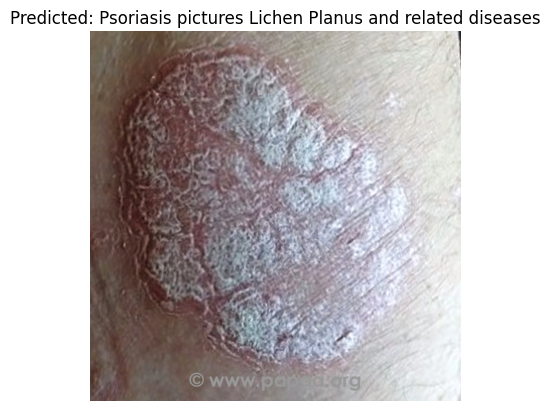

✅ Image 1 classified as: Psoriasis pictures Lichen Planus and related diseases


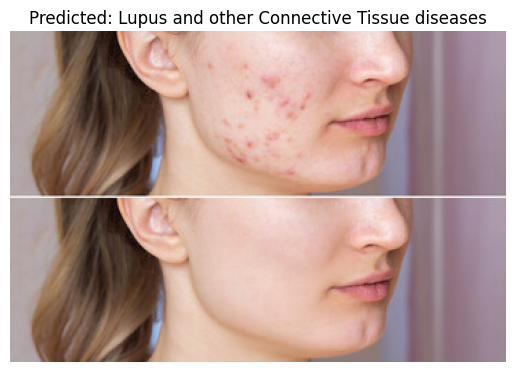

✅ Image 2 classified as: Lupus and other Connective Tissue diseases


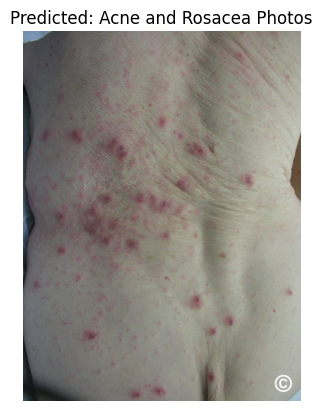

✅ Image 3 classified as: Acne and Rosacea Photos


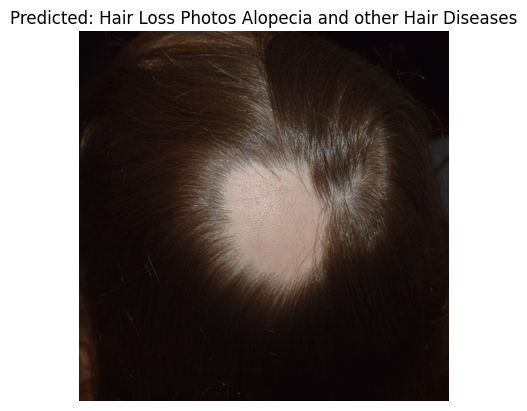

✅ Image 4 classified as: Hair Loss Photos Alopecia and other Hair Diseases


In [3]:
# ------------------------------
# 10. Test Model on Internet Images
# ------------------------------
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Define the same preprocessing transform used for validation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# List of image URLs to test
image_urls = [
    "https://www.papaa.org/media/3264/plaque-psoriasis.jpg",
    "https://t3.ftcdn.net/jpg/04/17/45/48/240_F_417454859_eFfQctXSN4NbbCNJNrjWV08HcUXBCRWg.jpg",
    "https://www.pcds.org.uk/imager/gallery/clinical/scabies/13233/Scabies_14_fee391183f15cb4d62773032fe0be92d.jpg",
    "https://journals.cambridgemedia.com.au/application/files/6116/4845/4020/Moussa_hair1.png"
]

model.eval()

for idx, url in enumerate(image_urls):
    try:
        # Load image from URL
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert('RGB')

        # Preprocess image
        input_tensor = transform(img).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            outputs = model(input_tensor)
            _, preds = torch.max(outputs, 1)
            pred_class = class_names[preds.item()]

        # Display image and prediction
        plt.figure()
        plt.imshow(img)
        plt.title(f"Predicted: {pred_class}")
        plt.axis("off")
        plt.show()

        print(f"✅ Image {idx+1} classified as: {pred_class}")

    except Exception as e:
        print(f"⚠️ Error processing image {idx+1}: {e}")
